## For GPT-4

Use your own API Key


In [ ]:
import pandas as pd
import openai
import sacrebleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

In [2]:

############ 1. Data Preparation for Model Training by Combine the datasets and prepare them for training ############
# Load cleaned Counsel-Chat dataset
counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/counsel_chat_data_after_data_preparation.csv')
display(counsel_chat_data.info())
display(counsel_chat_data.head(4))
# Rename columns for consistency with previous combined data format
counsel_chat_data.rename(
    columns={'questionText': 'prompt', 'answerText': 'response'}, inplace=True)


# Create new columns for the length of the text in questionText and answerText columns
counsel_chat_data['prompt_length'] = counsel_chat_data['prompt'].apply(len)
counsel_chat_data['response_length'] = counsel_chat_data['response'].apply(len)

# Display the first few rows to check the new columns
print(counsel_chat_data[['prompt', 'prompt_length', 'response', 'response_length']].head(4))

# Summary statistics for the length columns
print(counsel_chat_data[['prompt_length', 'response_length']].describe())

# Checking for missing values
print('\nMissing values in each column:\n', counsel_chat_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   questionID     1383 non-null   object
 1   questionTitle  1383 non-null   object
 2   questionText   1383 non-null   object
 3   questionUrl    1383 non-null   object
 4   topics         1376 non-null   object
 5   therapistName  1383 non-null   object
 6   therapistUrl   1383 non-null   object
 7   answerText     1383 non-null   object
 8   upvotes        1383 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 97.4+ KB


None

,questionID,questionTitle,questionText,questionUrl,topics,therapistName,therapistUrl,answerText,upvotes
0,5566fab2a64752d71ec3ca69,Escalating disagreements between mother and wife,my wife and mother are having tense disagreeme...,https://counselchat.com/questions/escalating-d...,Family Conflict,"Kristi King-Morgan, LMSW",https://counselchat.com/therapists/kristi-king...,<p>what you are describing is something psycho...,0
1,5566f94fa64752d71ec3ca64,I'm addicted to smoking. How can I stop?,"i'm planning to have baby, so i have to quit s...",https://counselchat.com/questions/i-m-addicted...,"Substance Abuse,Addiction",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>hi. good for you in planning ahead to do wh...,0
2,5567d26887a1cc0c3f3d8f46,Keeping secrets from my family,"i have secrets in my mind, and i don't know wh...",https://counselchat.com/questions/keeping-secr...,Family Conflict,Jeevna Bajaj,https://counselchat.com/therapists/jeevna-bajaj,<p>it sounds like keeping the secrets has beco...,0
3,556bed15c969ba5861709df5,The Underlying Causes of Being Possessive,i am extremely possessive in my relationships ...,https://counselchat.com/questions/the-underlyi...,"Behavioral Change,Social Relationships",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>hi there. it's great you are able to realiz...,0


                                              prompt  prompt_length  \
0  my wife and mother are having tense disagreeme...            387   
1  i'm planning to have baby, so i have to quit s...            215   
2  i have secrets in my mind, and i don't know wh...            278   
3  i am extremely possessive in my relationships ...            117   

                                            response  response_length  
0  <p>what you are describing is something psycho...             3450  
1  <p>hi. good for you in planning ahead to do wh...             1834  
2  <p>it sounds like keeping the secrets has beco...             1025  
3  <p>hi there. it's great you are able to realiz...             1319  
       prompt_length  response_length
count    1383.000000      1383.000000
mean      294.811280      1521.911786
std       264.029619      6972.597571
min        26.000000        11.000000
25%       147.000000       599.500000
50%       232.000000       959.000000
75%       349.0000

#### 2.


In [17]:
############ 2. Generate Responses Using GPT-4 Model via OpenAI API ############

openai.api_key = 'sk-proj-OpenAI_API_Key'


def generate_responses(data, model_name='gpt-4'):
    responses = []

    for index, row in data.iterrows():
        prompt = row['prompt']
        try:
            response = openai.ChatCompletion.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a mental health counselor. Your goal is to provide empathetic, supportive, and reflective responses to clients' questions. Focus on understanding the clients' concerns and offering thoughtful and compassionate guidance."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=0.7
            )
            responses.append(response.choices[0].message['content'].strip())
        except Exception as e:
            print(f"Error generating response for index {index}: {e}")
            responses.append("")

    data['generated_response'] = responses
    data.to_csv('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v3/generated_responses.csv', index=False)
    return data


# Generate responses for the dataset
counsel_chat_data = generate_responses(counsel_chat_data)

#### 3.


In [3]:

############ 2. Evaluation of Generated Responses ############
def evaluate_responses(data):
    bleu_scores = []
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for index, row in data.iterrows():
        reference = row['response']
        hypothesis = row['generated_response']

        try:
            # BLEU Score
            bleu_score = sacrebleu.sentence_bleu(
                hypothesis, [reference]).score / 100  # Normalize BLEU score
            bleu_scores.append(bleu_score)

            # ROUGE Score
            scorer = rouge_scorer.RougeScorer(
                ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
            scores = scorer.score(reference, hypothesis)
            for key in scores:
                rouge_scores[key].append(scores[key].fmeasure)

            print(f"Processed index {index}: BLEU = {bleu_score}, ROUGE-1 = {scores['rouge1'].fmeasure}, ROUGE-2 = {
                  scores['rouge2'].fmeasure}, ROUGE-L = {scores['rougeL'].fmeasure}")

        except Exception as e:
            print(f"Error processing index {index}: {e}")

    evaluation_results = {
        'bleu': sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0,
        'rouge1': sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1']) if rouge_scores['rouge1'] else 0,
        'rouge2': sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2']) if rouge_scores['rouge2'] else 0,
        'rougeL': sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL']) if rouge_scores['rougeL'] else 0
    }

    return evaluation_results


# Evaluate the model
counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v4/generated_responses.csv')
display(counsel_chat_data.head(4))
evaluation_results = evaluate_responses(counsel_chat_data)

print("Evaluation Results:", evaluation_results)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,questionID,questionTitle,prompt,questionUrl,topics,therapistName,therapistUrl,response,upvotes,generated_response
0,5566fab2a64752d71ec3ca69,Escalating disagreements between mother and wife,my wife and mother are having tense disagreeme...,https://counselchat.com/questions/escalating-d...,Family Conflict,"Kristi King-Morgan, LMSW",https://counselchat.com/therapists/kristi-king...,<p>what you are describing is something psycho...,0,I'm sorry to hear that you're dealing with thi...
1,5566f94fa64752d71ec3ca64,I'm addicted to smoking. How can I stop?,"i'm planning to have baby, so i have to quit s...",https://counselchat.com/questions/i-m-addicted...,"Substance Abuse,Addiction",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>hi. good for you in planning ahead to do wh...,0,I understand how challenging it can be to quit...
2,5567d26887a1cc0c3f3d8f46,Keeping secrets from my family,"i have secrets in my mind, and i don't know wh...",https://counselchat.com/questions/keeping-secr...,Family Conflict,Jeevna Bajaj,https://counselchat.com/therapists/jeevna-bajaj,<p>it sounds like keeping the secrets has beco...,0,"I'm really sorry that you're feeling this way,..."
3,556bed15c969ba5861709df5,The Underlying Causes of Being Possessive,i am extremely possessive in my relationships ...,https://counselchat.com/questions/the-underlyi...,"Behavioral Change,Social Relationships",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>hi there. it's great you are able to realiz...,0,I'm glad you took the first step by recognizin...


Processed index 0: BLEU = 0.0006537043473388961, ROUGE-1 = 0.24871794871794875, ROUGE-2 = 0.07197943444730076, ROUGE-L = 0.11282051282051282
Processed index 1: BLEU = 0.002685825395375031, ROUGE-1 = 0.25, ROUGE-2 = 0.03829787234042553, ROUGE-L = 0.12288135593220338
Processed index 2: BLEU = 0.0003113393851504554, ROUGE-1 = 0.13765182186234817, ROUGE-2 = 0.016326530612244896, ROUGE-L = 0.0728744939271255
Processed index 3: BLEU = 0.010856118945811464, ROUGE-1 = 0.29110512129380056, ROUGE-2 = 0.059620596205962065, ROUGE-L = 0.1347708894878706
Processed index 4: BLEU = 0.0004516370270181836, ROUGE-1 = 0.18571428571428575, ROUGE-2 = 0.02877697841726619, ROUGE-L = 0.08571428571428572
Processed index 5: BLEU = 7.134618878478475e-05, ROUGE-1 = 0.14285714285714285, ROUGE-2 = 0.0425531914893617, ROUGE-L = 0.08465608465608465
Processed index 6: BLEU = 0.004903190927072606, ROUGE-1 = 0.2658486707566462, ROUGE-2 = 0.04517453798767967, ROUGE-L = 0.11860940695296525
Processed index 7: BLEU = 0.00761

#### 4.


Data loaded successfully. Total records: 1383


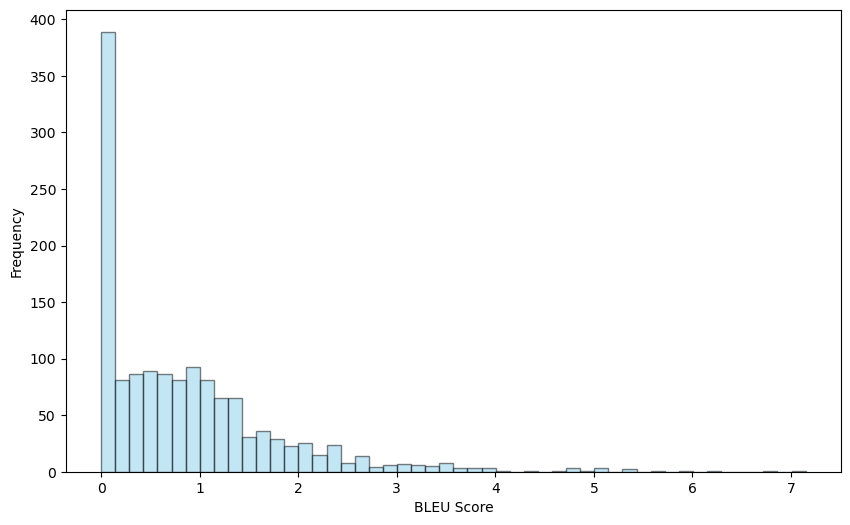

In [3]:
############ 3. Analyze BLEU Score Distribution ############

def calculate_bleu_scores(data):
    bleu_scores = []
    try:
        print(f"Data loaded successfully. Total records: {len(data)}")
    except Exception as e:
        print(f"Error loading data: {e}")

    for index, row in data.iterrows():
        reference = row['response']
        hypothesis = row['generated_response']
        bleu_score = sacrebleu.sentence_bleu(hypothesis, [reference]).score
        bleu_scores.append(bleu_score)

    data['bleu_score'] = bleu_scores
    return data


counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v4/generated_responses.csv')
evaluated_data = calculate_bleu_scores(counsel_chat_data)

# Plot Distribution:
plt.figure(figsize=(10, 6))
plt.hist(evaluated_data['bleu_score'], bins=50,
         color='skyblue', edgecolor='black', alpha=0.5)
#plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v4/gpt_4_bleu_score_distribution.png', dpi=600) #format='eps'
plt.show()

#### 5.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   questionID          1383 non-null   object 
 1   questionTitle       1383 non-null   object 
 2   prompt              1383 non-null   object 
 3   questionUrl         1383 non-null   object 
 4   topics              1376 non-null   object 
 5   therapistName       1383 non-null   object 
 6   therapistUrl        1383 non-null   object 
 7   response            1383 non-null   object 
 8   upvotes             1383 non-null   int64  
 9   generated_response  1383 non-null   object 
 10  bleu_score          1383 non-null   float64
dtypes: float64(1), int64(1), object(9)
memory usage: 119.0+ KB
None


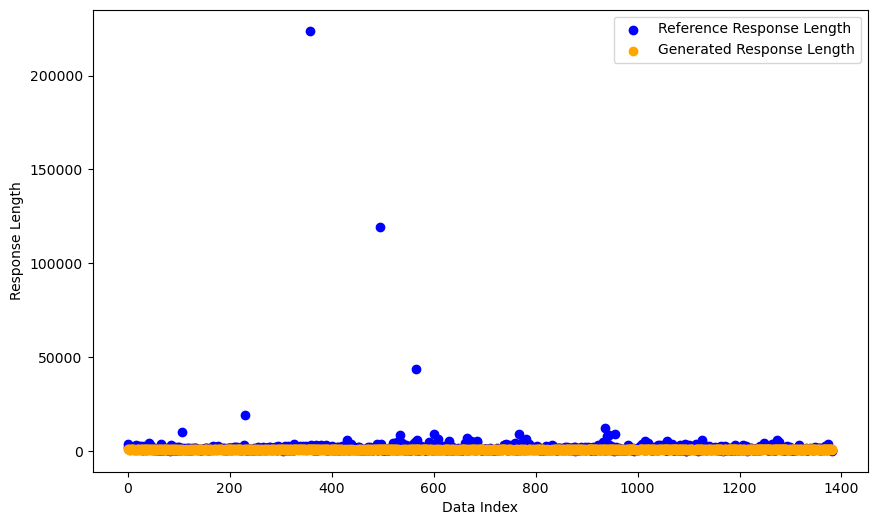

Most common words in generated responses:
to: 6347
a: 3631
and: 3547
your: 3236
that: 3020
you: 2518
the: 2123
It's: 1755
you're: 1716
with: 1695
or: 1533
I'm: 1526
in: 1517
really: 1511
be: 1444
of: 1372
important: 1307
can: 1298
this: 1149
it's: 1077


In [17]:
############ 4. Length Analysis of Generated Responses ############
print(evaluated_data.info())
evaluated_data['reference_length'] = evaluated_data['response'].apply(len)
evaluated_data['generated_length'] = evaluated_data['generated_response'].apply(
    len)

plt.figure(figsize=(10, 6))
plt.scatter(evaluated_data.index,
            evaluated_data['reference_length'], color='blue', label='Reference Response Length')
plt.scatter(evaluated_data.index,
            evaluated_data['generated_length'], color='orange', label='Generated Response Length')

plt.xlabel('Data Index')
plt.ylabel('Response Length')
#plt.title('Length Comparison of Reference and Generated Responses')
plt.legend()
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v4/gpt_4_length_analysis.png',  dpi=600) #format='eps',
plt.show()

############ 5. Content Analysis of Generated Responses ############

generated_responses = evaluated_data['generated_response'].tolist()
word_counts = Counter(" ".join(generated_responses).split())

common_words = word_counts.most_common(20)
print("Most common words in generated responses:")
for word, count in common_words:
    print(f"{word}: {count}")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dipendrapant/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                  generated_response  sentiment    pos    neu  \
0  I'm sorry to hear that you're dealing with thi...   0.150000  0.186  0.706   
1  I understand how challenging it can be to quit...   0.149735  0.153  0.792   
2  I'm really sorry that you're feeling this way,...  -0.100000  0.237  0.736   
3  I'm glad you took the first step by recognizin...   0.173077  0.226  0.634   
4  I'm really sorry to hear that you're feeling t...  -0.100000  0.228  0.747   

     neg  compound  
0  0.109    0.8923  
1  0.055    0.8732  
2  0.027    0.8832  
3  0.140    0.9081  
4  0.025    0.8832  
Overall Sentiment Score: 0.03936209496782401
Average Emotion Scores:
pos         0.203584
neu         0.737302
neg         0.059106
compound    0.763987
dtype: float64


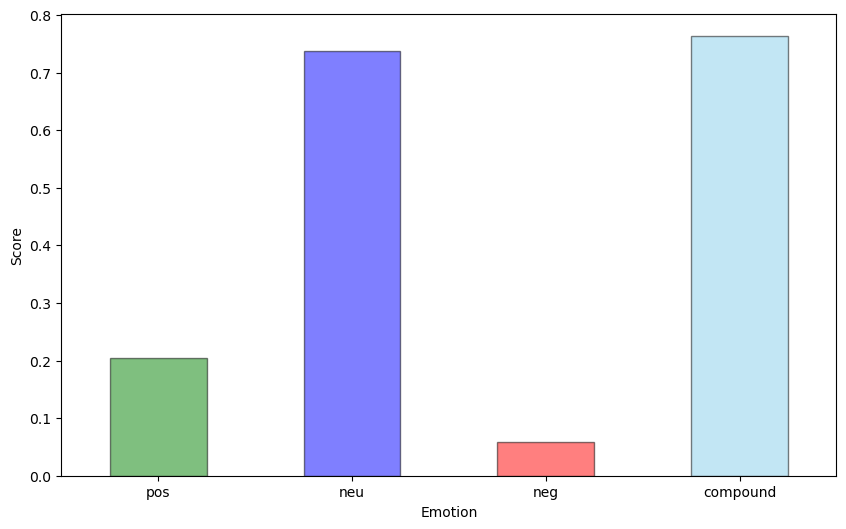

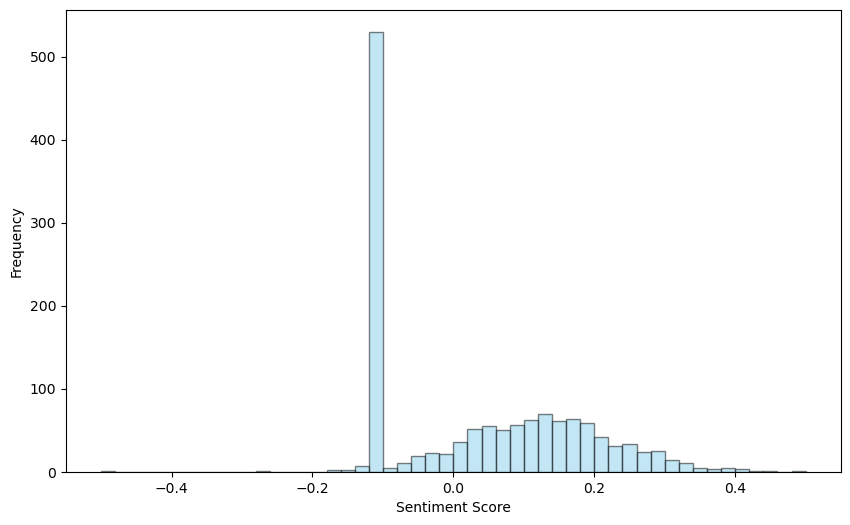

In [18]:


############ 6. Sentiment Analysis and Emotion Detection ############

# Function to perform sentiment analysis


def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Function to perform emotion detection


def detect_emotions(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)

# Adding sentiment analysis and emotion detection to the evaluation


def evaluate_responses_with_sentiment(data):
    # Perform sentiment analysis
    data['sentiment'] = data['generated_response'].apply(
        lambda x: analyze_sentiment(x))

    # Perform emotion detection
    emotion_scores = data['generated_response'].apply(
        lambda x: detect_emotions(x))
    data = pd.concat([data, emotion_scores.apply(pd.Series)], axis=1)

    return data


# Apply the extended evaluation function
evaluated_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v4/generated_responses.csv')
evaluated_data_with_sentiment = evaluate_responses_with_sentiment(
    evaluated_data)

# Display some sentiment and emotion analysis results
print(evaluated_data_with_sentiment[[
      'generated_response', 'sentiment', 'pos', 'neu', 'neg', 'compound']].head())

############ 7. Summarize Sentiment and Emotion Scores ############

# Calculate overall sentiment score
overall_sentiment = evaluated_data_with_sentiment['sentiment'].mean()
print(f"Overall Sentiment Score: {overall_sentiment}")

# Calculate average emotion scores
average_emotions = evaluated_data_with_sentiment[[
    'pos', 'neu', 'neg', 'compound']].mean()
print(f"Average Emotion Scores:\n{average_emotions}")

# Plotting the emotion distributions
plt.figure(figsize=(10, 6))
average_emotions.plot(kind='bar', color=[
                      'green', 'blue', 'red', 'skyblue'], edgecolor='black', alpha=0.5)
#plt.title('Average Emotion Scores')
plt.ylabel('Score')
plt.xlabel('Emotion')
plt.xticks(rotation=0)
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v4/gpt_4_emotion_scores.png',dpi=600)
plt.show()

############ 8. Plot Histogram of Sentiment Scores ############

# Plot the histogram of sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(evaluated_data_with_sentiment['sentiment'],
         bins=50, color='skyblue', edgecolor='black', alpha=0.5)
#plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v4/gpt_4_sentiment_score_distribution.png', dpi=600)
plt.show()

**Comparision of sentiment and emotion with reference text**


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dipendrapant/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                 questionID                                     questionTitle  \
0  5566fab2a64752d71ec3ca69  Escalating disagreements between mother and wife   
1  5566f94fa64752d71ec3ca64          I'm addicted to smoking. How can I stop?   
2  5567d26887a1cc0c3f3d8f46                    Keeping secrets from my family   
3  556bed15c969ba5861709df5         The Underlying Causes of Being Possessive   
4  556ba115c969ba5861709de6         Can I control anxiety without medication?   

                                              prompt  \
0  my wife and mother are having tense disagreeme...   
1  i'm planning to have baby, so i have to quit s...   
2  i have secrets in my mind, and i don't know wh...   
3  i am extremely possessive in my relationships ...   
4  i had a head injury a few years ago and my min...   

                                         questionUrl  \
0  https://counselchat.com/questions/escalating-d...   
1  https://counselchat.com/questions/i-m-addicted...   
2  https

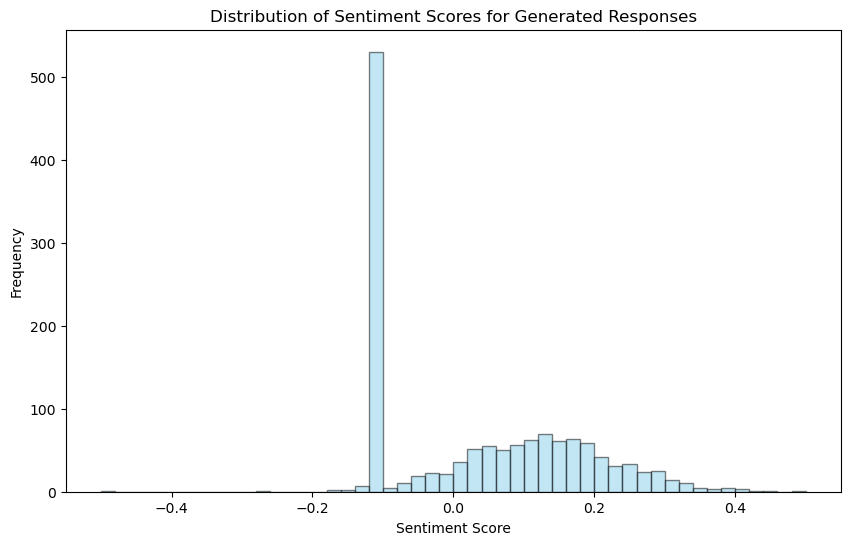

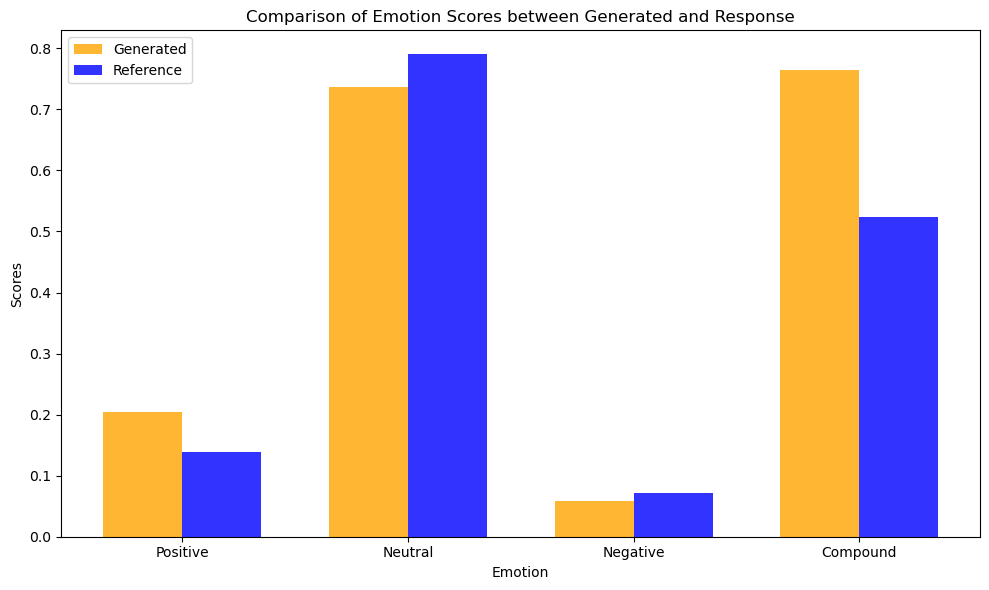

In [12]:
############ 6. Sentiment Analysis and Emotion Detection ############

# Function to perform sentiment analysis
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Function to perform emotion detection
def detect_emotions(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)

# Adding sentiment analysis and emotion detection to the evaluation
def evaluate_responses_with_sentiment(data):
    # Perform sentiment analysis on both columns
    data['generated_sentiment'] = data['generated_response'].apply(analyze_sentiment)
    data['response_sentiment'] = data['response'].apply(analyze_sentiment)

    # Perform emotion detection on both columns
    generated_emotion_scores = data['generated_response'].apply(detect_emotions).apply(pd.Series)
    response_emotion_scores = data['response'].apply(detect_emotions).apply(pd.Series)

    # Concatenate emotion scores to the original data with prefixes
    data = pd.concat([data, generated_emotion_scores.add_prefix('generated_'), response_emotion_scores.add_prefix('response_')], axis=1)
    return data

# Apply the extended evaluation function
evaluated_data = pd.read_csv('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v4/generated_responses.csv')
evaluated_data_with_sentiment = evaluate_responses_with_sentiment(evaluated_data)

# Display some sentiment and emotion analysis results
print(evaluated_data_with_sentiment.head())

############ 7. Plot Histogram of Sentiment Scores ############

# Plot the histogram of sentiment scores for generated responses
plt.figure(figsize=(10, 6))
plt.hist(evaluated_data_with_sentiment['generated_sentiment'],
         bins=50, color='skyblue', edgecolor='black', alpha=0.5)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Generated Responses')
plt.show()

############ 8. Plot Grouped Emotion Scores ############

# Calculate average emotion scores
average_generated_emotions = evaluated_data_with_sentiment[['generated_pos', 'generated_neu', 'generated_neg', 'generated_compound']].mean()
average_response_emotions = evaluated_data_with_sentiment[['response_pos', 'response_neu', 'response_neg', 'response_compound']].mean()

# Creating indices for grouped bar chart
index = np.arange(len(average_generated_emotions))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(index, average_generated_emotions, bar_width, label='Generated', color='orange', alpha=0.8)
plt.bar(index + bar_width, average_response_emotions, bar_width, label='Reference', color='blue', alpha=0.8)

plt.xlabel('Emotion')
plt.ylabel('Scores')
plt.title('Comparison of Emotion Scores between Generated and Response')
plt.xticks(index + bar_width / 2, ('Positive', 'Neutral', 'Negative', 'Compound'))
plt.legend()
plt.tight_layout()
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v4/gpt_4_emotion_scores_comparision.png',dpi=600)
plt.show()


**Summary Statistics of the genereated response of both GPTs**


In [13]:
# Summary statistics for the length columns

counsel_chat_data_v3 = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v3/generated_responses.csv')



counsel_chat_data_v4 = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/TechnicalEvaluationGPT4/data/result/v4/generated_responses.csv')

# print column names in both
print(counsel_chat_data_v3.columns)
print(counsel_chat_data_v4.columns)

# Max of the generated response of both datasets
counsel_chat_data_v3['response_length'] = counsel_chat_data_v3['generated_response'].apply(len)
counsel_chat_data_v4['response_length'] = counsel_chat_data_v4['generated_response'].apply(len)

# Display statistical summary for the text lengths
summary_v3 = counsel_chat_data_v3['response_length'].describe()
summary_v4 = counsel_chat_data_v4['response_length'].describe()

# Extracting the required statistics
required_stats = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']

# Printing the statistics for the first dataset
print("CounselChat Data V3 - Generated Response Length Statistics:")
for stat in required_stats:
    print(f"{stat.capitalize()}: {summary_v3[stat]}")

# Printing the statistics for the second dataset
print("\nCounselChat Data V4 - Generated Response Length Statistics:")
for stat in required_stats:
    print(f"{stat.capitalize()}: {summary_v4[stat]}")

Index(['questionID', 'questionTitle', 'prompt', 'questionUrl', 'topics',
       'therapistName', 'therapistUrl', 'response', 'upvotes',
       'generated_response'],
      dtype='object')
Index(['questionID', 'questionTitle', 'prompt', 'questionUrl', 'topics',
       'therapistName', 'therapistUrl', 'response', 'upvotes',
       'generated_response'],
      dtype='object')
CounselChat Data V3 - Generated Response Length Statistics:
Mean: 782.3774403470716
Std: 92.46348274427214
Min: 213.0
25%: 771.0
50%: 799.0
75%: 825.0
Max: 906.0

CounselChat Data V4 - Generated Response Length Statistics:
Mean: 541.586406362979
Std: 247.77494839846753
Min: 167.0
25%: 247.0
50%: 689.0
75%: 764.0
Max: 902.0
